In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from sklearn import set_config
set_config(display="text")

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [3]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

## Colunas que vão receber o preprocessamento:

In [7]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"] # Categórica sem ordenamento

coluna_ordinal_encoder = ["median_income_cat"] # Categórica com ordenamento

colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_standard_scaler = ["latitude", "longitude", "housing_median_age"]

colunas_power_transformer = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder + colunas_standard_scaler)

## Preprocessamento:

In [8]:
# Tudo isso aqui são pipelines de processos alternativos. Logo eu consigo acessá-los com a seguinte sintaxe: regressor__preprocessor
# 
preprocessamento_categoricas = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        # Vai determinar automaticamente quais são as ordens (quando são mais simples).
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder)
        # drop="first" vai tirar a primeira coluna pra impedir a redundância. Dentre 3 cores, vai pegar as duas últimas.
        # Se não for nenhuma das duas últimas, lógicamente será a primeira.
    ],
    remainder="passthrough" # Vai passar pelas demais colunas sem fazer qualquer alteração.
)

preprocessamento_simples = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder), # Vai transformar categorias não ordinais em números, mas sem serem ordinais
        # Dentro de uma tabela. 1 sigfica sucesso e 0 falha. 
        # Se em um tabela com 3 colunas (azul, vermelho e amarelo) a coluna azul recebeu 1, logo houve sucesso
        ("robust_scaler", RobustScaler(), colunas_robust_scaler) # É como um StandardScaler, só que menos sensível a outliers
        # Vai normalizar os dados pra que eles fiquem na mesma escala, assim como o StandardScaler
    ],
)

preprocessamento_completo = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("scaler", StandardScaler(), colunas_standard_scaler),
        ("power_transformer", PowerTransformer(), colunas_power_transformer)
        # Vai aproximar os dados de uma distribuição normal
    ],
)

## Criando o X e y:

In [18]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

## Configurando o grid_search:

In [11]:
param_grid = {
    "regressor__preprocessor": [preprocessamento_categoricas, preprocessamento_simples, preprocessamento_completo],
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution="normal")]
}

In [12]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento_completo,
    target_transformer=PowerTransformer(),
    param_grid=param_grid
)
grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                          

In [13]:
grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                          

In [14]:
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('ordinal_encoder', OrdinalEncoder(),
                                  ['median_income_cat']),
                                 ('one_hot', OneHotEncoder(drop='first'),
                                  ['ocean_proximity'])]),
 'transformer': QuantileTransformer(output_distribution='normal')}

In [15]:
grid_search.best_score_

np.float64(-54417.878935974106)

In [16]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)
coefs

,coeficiente
one_hot__ocean_proximity_INLAND,-0.457314
remainder__longitude,-0.295546
remainder__latitude,-0.289021
remainder__population_per_household,-0.280892
one_hot__ocean_proximity_NEAR BAY,-0.203271
one_hot__ocean_proximity_NEAR OCEAN,-0.061653
remainder__total_bedrooms,-0.000228
remainder__total_rooms,-0.000061
remainder__population,-0.000034
remainder__households,0.000856


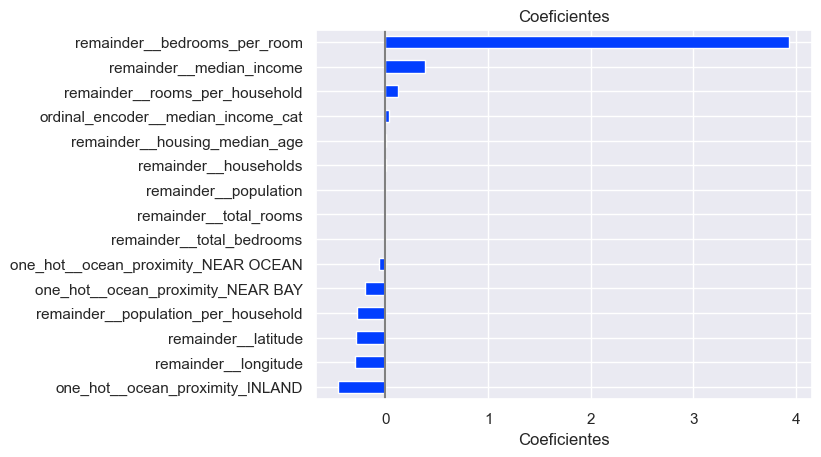

In [17]:
plot_coeficientes(coefs)

In [19]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"), # Esse é só a referência
        "target_transformer": None        
    },
    "LinearRegression": {
        "preprocessor": preprocessamento_categoricas,
        "regressor": LinearRegression(), # Esse é sem o target_transformer
        "target_transformer": None
    },
    "LinearRegression_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer":grid_search.best_estimator_.transformer_
    }
    
}

resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.003509,0.00301,-0.000081,-77516.042766,-96239.705692,0.006519
1,DummyRegressor,0.001504,0.003031,-0.000146,-75787.787194,-95217.629397,0.004534
2,DummyRegressor,0.002006,0.002131,-0.001737,-76753.598961,-96253.253947,0.004138
3,DummyRegressor,0.001,0.002393,-0.000101,-76837.804811,-95983.885799,0.003393
4,DummyRegressor,0.000718,0.003026,-0.000114,-76617.245449,-96182.764729,0.003743
5,LinearRegression,0.014394,0.005215,0.682162,-39855.690921,-54254.958115,0.019609
6,LinearRegression,0.012542,0.006262,0.66999,-40272.565406,-54695.230224,0.018804
7,LinearRegression,0.01364,0.00586,0.649247,-42178.059246,-56955.988686,0.0195
8,LinearRegression,0.014549,0.005021,0.669873,-40806.492452,-55146.31876,0.01957
9,LinearRegression,0.015078,0.005058,0.669023,-40788.496555,-55331.351171,0.020135


In [20]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.001747,0.002718,-0.000436,-76702.495836,-95975.447913,0.004466
LinearRegression,0.014041,0.005483,0.668059,-40780.260916,-55276.769391,0.019524
LinearRegression_grid_search,0.019247,0.006142,0.678032,-38681.388022,-54436.274055,0.025389


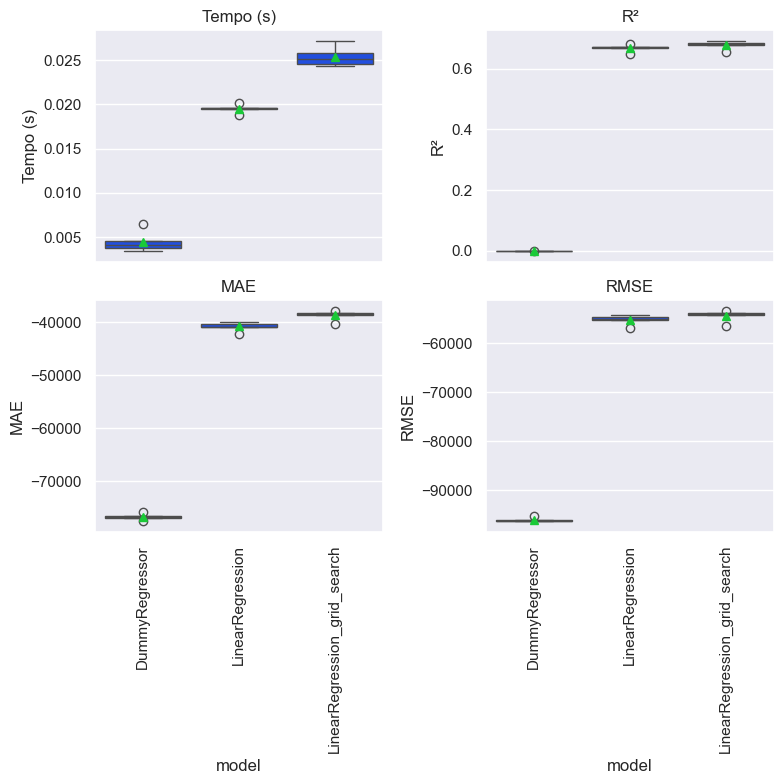

In [21]:
plot_comparar_metricas_modelos(df_resultados)

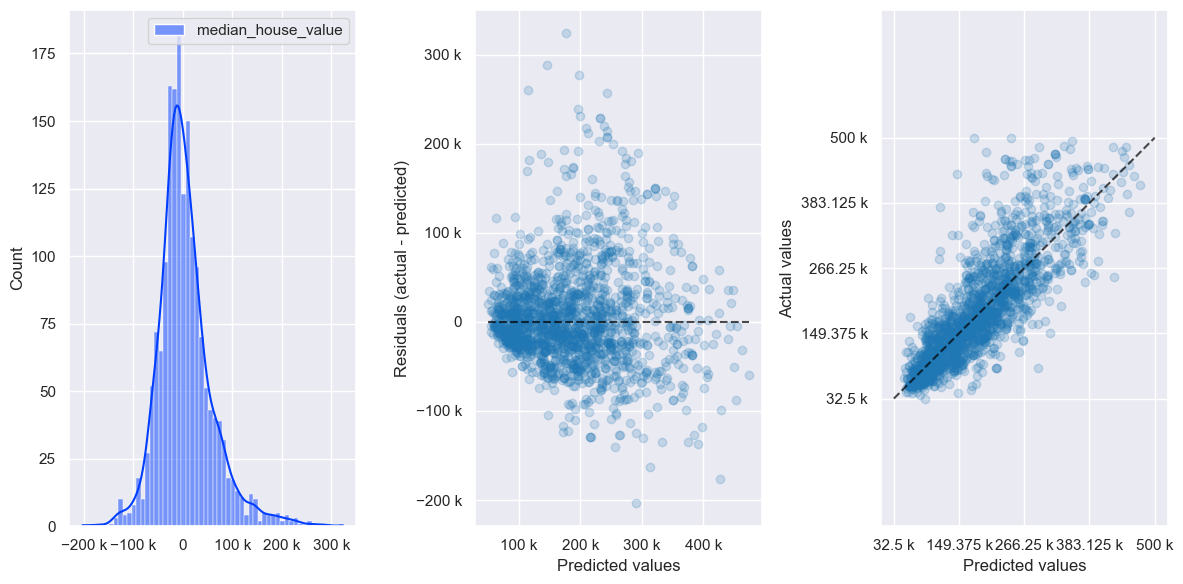

In [22]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)